# Explore here

It's recommended to use this notebook for exploration purposes.

Status: 200 - Got it!
Found 27 tables on the page.
First few glimpses of our data:
  Rank                 Song                 Artist(s) Streams (billions)  \
0    1    "Blinding Lights"                The Weeknd              4.791   
1    2       "Shape of You"                Ed Sheeran              4.310   
2    3  "Someone You Loved"             Lewis Capaldi              3.865   
3    4            "Starboy"  The Weeknd and Daft Punk              3.838   
4    5          "As It Was"              Harry Styles              3.832   

        Release date Ref.  
0   29 November 2019  [2]  
1     6 January 2017  [3]  
2    8 November 2018  [4]  
3  21 September 2016  [5]  
4       1 April 2022  [6]  

Cleaned and ready data:
  Rank                Track               Lead Artist  \
0    1    "Blinding Lights"                The Weeknd   
1    2       "Shape of You"                Ed Sheeran   
2    3  "Someone You Loved"             Lewis Capaldi   
3    4            "Starboy"  The Weeknd

/tmp/ipykernel_6883/280601735.py:74: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/vscode/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


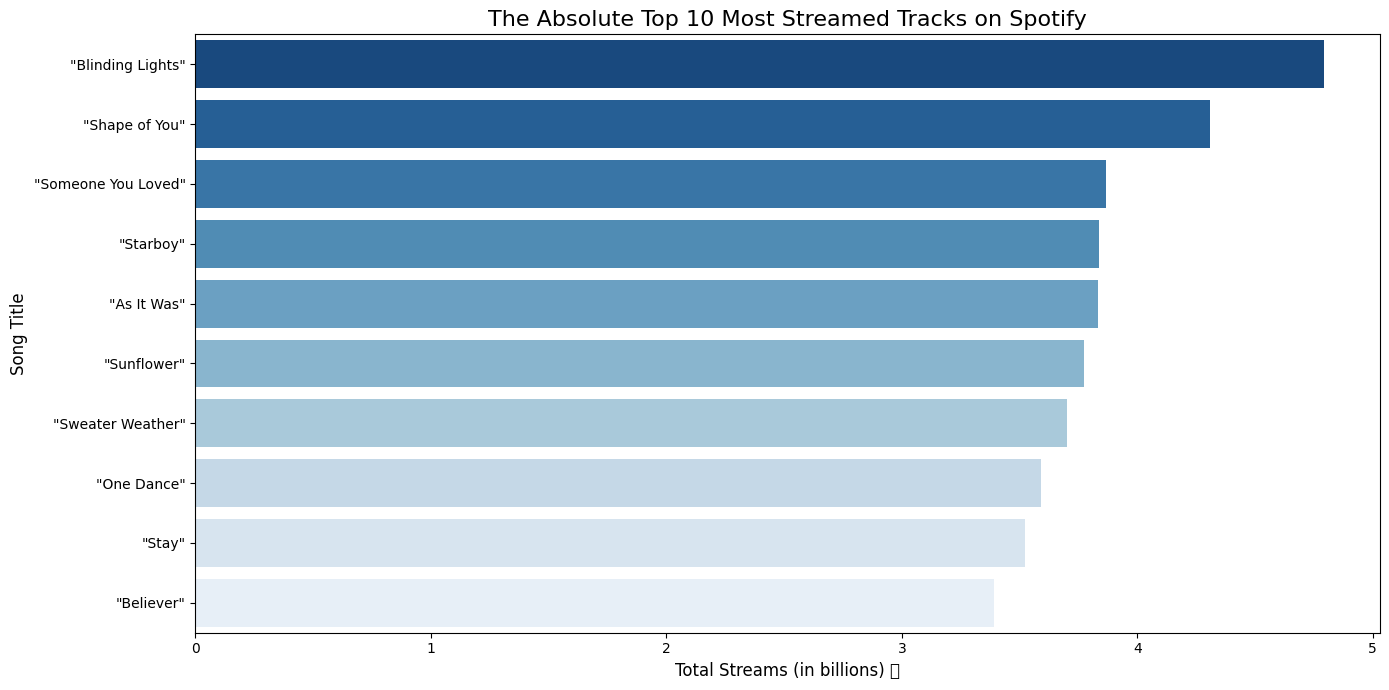

/tmp/ipykernel_6883/280601735.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=cleaned_ranking, x="Year Released", order=sorted(cleaned_ranking["Year Released"].dropna().unique()), palette="Greens_r") # Another color palette
/tmp/ipykernel_6883/280601735.py:85: UserWarning: Glyph 128467 (\N{SPIRAL CALENDAR PAD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/vscode/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128467 (\N{SPIRAL CALENDAR PAD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


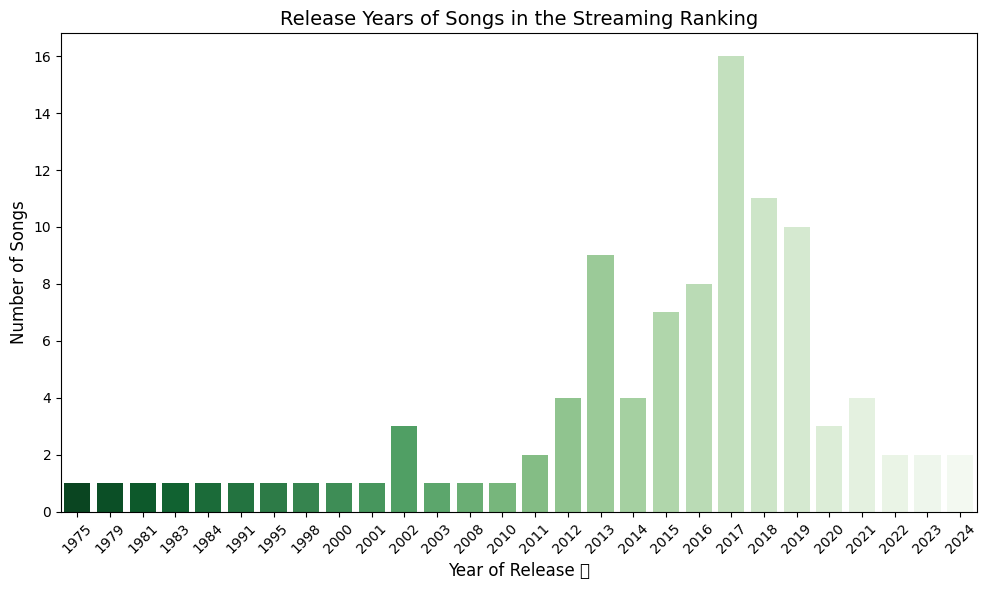

In [46]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import io

# HTML from web:
url = "https://en.wikipedia.org/wiki/List_of_most-streamed_songs_on_Spotify"
response = requests.get(url)

if response.status_code != 200:
    raise Exception(f"Oops! Couldn't get the page (status code: {response.status_code})")

print("Status:", response.status_code, "- Got it!")

# HTML to Pandas
html_content = io.StringIO(response.text)
tables_found = pd.read_html(html_content)
print(f"Found {len(tables_found)} tables on the page.")

# The first table
spotify_ranking = tables_found[0]
print("First few glimpses of our data:")
print(spotify_ranking.head())

# DATA CLEANING

# Renaming columns to something easier to work with
spotify_ranking.columns = ["Rank", "Track", "Lead Artist", "Total Streams (billions)", "Release Date", "Source"]

# COPY
cleaned_ranking = spotify_ranking.copy()

cleaned_ranking["Track"] = cleaned_ranking["Track"].str.replace(r"\[.*?\]", "", regex=True)
cleaned_ranking["Lead Artist"] = cleaned_ranking["Lead Artist"].str.replace(r"\[.*?\]", "", regex=True)

# 
cleaned_ranking = cleaned_ranking[cleaned_ranking["Total Streams (billions)"].astype(str).str.contains(r"^\d+(?:\.\d+)?$", na=False)].copy()

# stream numbers IN FLOATS
cleaned_ranking["Total Streams (billions)"] = cleaned_ranking["Total Streams (billions)"].astype(float)

# release dates
cleaned_ranking["Release Date"] = pd.to_datetime(cleaned_ranking["Release Date"], errors="coerce")

print("\nCleaned and ready data:")
print(cleaned_ranking.head())

# (SQLite database) 💾
conn = sqlite3.connect("my_spotify_charts.db")

# cleaned data to the database table
cleaned_ranking.to_sql("top_streamed_songs", conn, if_exists="replace", index=False)
cursor = conn.cursor()

# 
cursor.execute("SELECT COUNT(*) FROM top_streamed_songs")
print("Number of songs saved to the database:", cursor.fetchone()[0])

conn.commit()
conn.close()

# GRAPHS

# TOP 10 songs:
top_ten_tracks = cleaned_ranking.nlargest(10, "Total Streams (billions)")
plt.figure(figsize=(14, 7)) # Slightly wider figure
sns.barplot(data=top_ten_tracks, x="Total Streams (billions)", y="Track", hue="Track", palette="Blues_r", legend=False) # Using a different color palette
plt.title("The Absolute Top 10 Most Streamed Tracks on Spotify", fontsize=16) # More engaging title
plt.xlabel("Total Streams (in billions) 🚀", fontsize=12) # Added an emoji and made the label more exciting
plt.ylabel("Song Title", fontsize=12)
plt.tight_layout()
plt.show()

# DATES
cleaned_ranking["Year Released"] = cleaned_ranking["Release Date"].dt.year
plt.figure(figsize=(10, 6))
sns.countplot(data=cleaned_ranking, x="Year Released", order=sorted(cleaned_ranking["Year Released"].dropna().unique()), palette="Greens_r") # Another color palette
plt.title("Release Years of Songs in the Streaming Ranking", fontsize=14) # Personalized title
plt.xlabel("Year of Release 🗓️", fontsize=12) # Added an emoji
plt.ylabel("Number of Songs", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

